<a href="https://colab.research.google.com/github/wxya2017/GR5242-CIFAR10/blob/master/final_model_editted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import cv2
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot
from scipy.misc import toimage


import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from keras.callbacks import TensorBoard, LearningRateScheduler


# Connecting Google Drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
os.chdir("drive/5242") 

In [4]:
!ls

 data			     logs_keras   ngrok-stable-linux-amd64.zip.1
 final_model_editted.ipynb   model	 'previous result'
 keras_model.ipynb	     ngrok


In [0]:
# Run Tensorflow in the background - note that we specify the log 
# directory we want to look at
LOG_DIR = 'logs_keras'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
# Download and unzip ngrok - you will only need to do this once per session
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

In [9]:
# Launch the ngrok background process
get_ipython().system_raw('./ngrok http 6006 &')

# Get the public URL and be sorted!
! curl -s http://localhost:4040/api/tunnels | python3 -c\
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://94cef820.ngrok.io


# Self-Defined Functions

In [0]:
def lr_schedule(epoch):
    # scheduler for CNN
    lrate = 0.001
    if epoch > 100:
        lrate = 0.0005
    elif epoch > 175:
        lrate = 0.0003        
    return lrate

def scheduler(epoch):
    learning_rate = 0.08
    if epoch >= 81:
        learning_rate = 0.01
    if epoch >= 122:
        learning_rate = 0.001
    return learning_rate

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
    
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

# Data Preprocess

In [0]:
labels = unpickle('data/batches.meta')[b'label_names']

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("===>training data shape is "+ str(x_train.shape))
print("===>test data shape is "+ str(x_test.shape))
print("===>training label shape is "+ str(y_train.shape))
print("===>test label shape is "+ str(y_test.shape))

170500096/170498071 [==============================] - 61s 0us/step
===>training data shape is (50000, 32, 32, 3)
===>test data shape is (10000, 32, 32, 3)
===>training label shape is (50000, 1)
===>test label shape is (10000, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


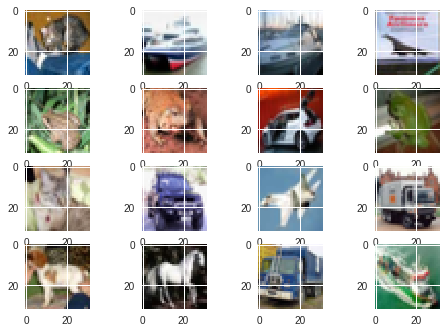

In [13]:
show_imgs(x_test[:16])

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)


In [0]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train - mean)/(std + 1e-7)
x_test = (x_test - mean)/(std + 1e-7)
x_valid = (x_valid - mean)/(std + 1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes) # one-hot
y_valid = np_utils.to_categorical(y_valid,num_classes) # one-hot
y_test = np_utils.to_categorical(y_test,num_classes)   # one-hot

In [17]:
print("===>test label shape is "+ str(y_test.shape))
print(y_train.shape)
print(y_valid.shape)

===>test label shape is (10000, 10)
(40000, 10)
(10000, 10)


In [0]:
# #data augmentation
# old version
# datagen = ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,                     
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
#     )

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
#     vertical_flip=True
    )
datagen.fit(x_train)

# Baseline

In [0]:
def build_model_base(num_classes = 10, baseMapNum = 32):
    '''build weight decay model'''
    model_base = Sequential()
    model_base.add(Conv2D(baseMapNum, (3,3), name='conv1', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=x_train.shape[1:]))
    model_base.add(Activation('relu', name='relu1'))
    
    model_base.add(Conv2D(baseMapNum, (3,3), name='conv2', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu2'))
    model_base.add(MaxPooling2D(pool_size=(2,2), name='maxp1'))
    model_base.add(Dropout(0.5, name='drop1'))
    
    model_base.add(Conv2D(2*baseMapNum, (3,3), name='conv3', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu3'))
    
    model_base.add(Conv2D(2*baseMapNum, (3,3), name='conv4', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu4'))
    model_base.add(MaxPooling2D(pool_size=(2,2), name='maxp2'))
    model_base.add(Dropout(0.3, name='drop2'))


    model_base.add(Flatten())
    model_base.add(Dense(num_classes, activation='softmax', name='dense'))
    
    model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    return model_base


In [20]:
baseline = build_model_base()
print(baseline.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
relu2 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
__________

In [0]:
# do not run after training complete!!!
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/baseline', write_graph=True)
datagen.fit(x_train)
#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(x_train.shape[0]/128)
fit_history_baseline = baseline.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                            steps_per_epoch=iterations,
                                            epochs=epochs,
                                            verbose=1,
                                            validation_data=(x_valid,y_valid),
                                            callbacks=[tbCallBack])
                    
baseline.save('model/baseline.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

In [24]:
baseline_evalu = baseline.evaluate(x_test, y_test, batch_size=128, verbose=1)
acc = baseline_evalu[1]; loss = baseline_evalu[0]
print('\nBaseline accuracy: %.3f loss: %.3f' % (acc*100, loss))

# model_decay_test = load_model('model/model_weight_decay_test.h5')

10000/10000 [==============================] - 1s 111us/step

Baseline accuracy: 80.590 loss: 0.687


Text(69,0.5,'Predicted label')

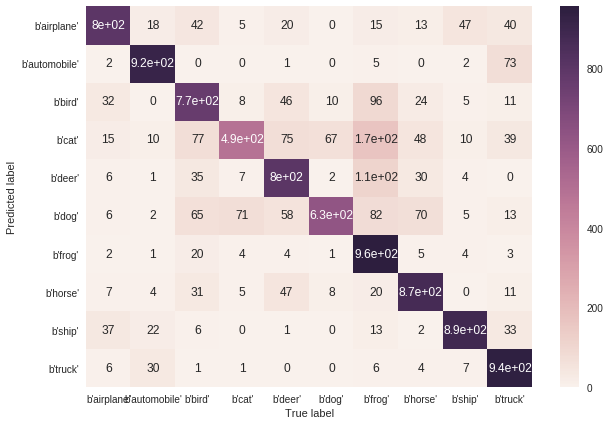

In [29]:
y_prob_base = baseline.predict(x_test) 
y_pred_base = y_prob_base.argmax(axis=-1)
y_true = np.where(y_test == 1)[1]
cm = confusion_matrix(y_true, y_pred_base, labels = range(10))
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [31]:
from keras.models import Model
layer_name = 'conv1'
intermediate_layer_model = Model(inputs=baseline.input,                 
                                 outputs=baseline.get_layer(layer_name).output)#你创建新的模型
#这个新的模型截取了原始模型中从输入到某个层（你想要得到结果的那一层）的一部分，
intermediate_output = intermediate_layer_model.predict(x_train[5:6])#这个数据就是原始模型的输入数据，
intermediate_output.shape

(1, 32, 32, 32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


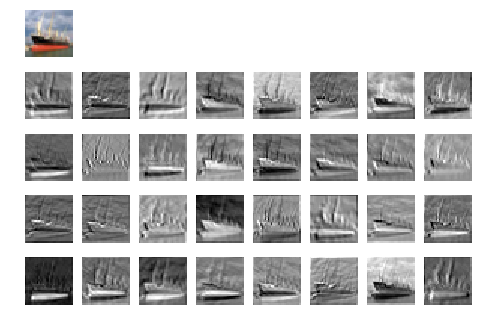

In [43]:
plt.subplot(5,8,1)
plt.imshow(toimage(x_train[5]))
plt.axis('off')
for _ in range(32):
    show_img = intermediate_output[:,:,:, _]
    show_img.shape = [32, 32]
    plt.subplot(5, 8, _ + 9)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

# CNN

In [0]:
def model_cnn(weight_decay = 1e-4, no_dropout = False):
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if no_dropout == False:
        model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if no_dropout == False:
        model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if no_dropout == False:
        model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    #model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(Activation('elu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if no_dropout == False:
        model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    return(model)


In [0]:
model_CNN = model_cnn()
model_CNN.summary()

In [0]:
#training
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/CNN', write_graph=True)

batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model_CNN.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_CNN.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=250,\
                    verbose=1,validation_data=(x_valid,y_valid),callbacks=[tbCallBack, LearningRateScheduler(lr_schedule)])

model_CNN.save('model/cnn.h5')

In [0]:
#testing
scores = model_CNN.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# NIN

In [0]:
def build_model_NIN(num_classes = 10, baseMapNum = 32):
    '''build NIN model: 
    '''
    model= Sequential()
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001), input_shape=train_x.shape[1:]))
    model.add(BatchNormalization(name='batchn1'))
    model.add(Activation('relu', name='relu1'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp1_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(Conv2D(baseMapNum*3, (1,1), name='mlp1_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp1'))

    
    model.add(Conv2D(baseMapNum*6, (5,5), name='conv2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn5'))
    model.add(Activation('relu', name='relu5'))
    model.add(Conv2D(baseMapNum*6, (1,1), name='mlp2_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp2'))
    
    
    model.add(Conv2D(baseMapNum*5, (3,3), name='conv3', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp3_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn8'))
    model.add(Activation('relu', name='relu8'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp3_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn9'))
    model.add(Activation('relu', name='relu9'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same', name='maxp3'))
#     model.add(Dropout(0.5, name='drop3'))
    
    model.add(Conv2D(baseMapNum*5, (3,3), name='conv4', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn10'))
    model.add(Activation('relu', name='relu10'))
    model.add(Conv2D(baseMapNum*5, (1,1), name='mlp4_1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn11'))
    model.add(Activation('relu', name='relu11'))
    model.add(Conv2D(num_classes, (1,1), name='mlp4_2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization(name='batchn12'))
    model.add(Activation('relu', name='relu12'))
    
    model.add(GlobalAveragePooling2D(name='avgp1'))
    model.add(Activation('softmax'))
    
    opt = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

In [0]:
NIN = build_model_NIN()
NIN.summary()

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras/NIN_deep2_ep250',write_graph=True)
change_lr = LearningRateScheduler(scheduler)
datagen.fit(x_train)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(x_train.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_250 = NIN.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                        steps_per_epoch=iterations,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=(x_valid,y_valid),
                                        callbacks=[change_lr2, tbCallBack])
NIN.save('model/nin_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

# 中间层输出

In [0]:
from keras.models import Model
model = load_model('model/nin_ep250.h5')  

In [0]:
print(model.summary())

In [0]:
layer_name = 'conv1'
intermediate_layer_model = Model(inputs=model.input,                 
                                 outputs=model.get_layer(layer_name).output)#你创建新的模型
#这个新的模型截取了原始模型中从输入到某个层（你想要得到结果的那一层）的一部分，
intermediate_output = intermediate_layer_model.predict(train_x[5:6])#这个数据就是原始模型的输入数据，

In [0]:
intermediate_output.shape

(1, 8, 8, 10)

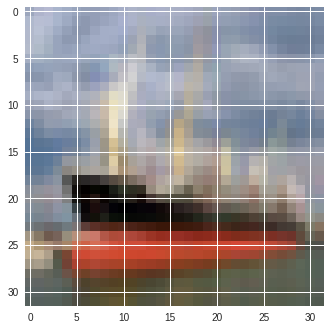

In [0]:
plt.imshow(x_train[5])

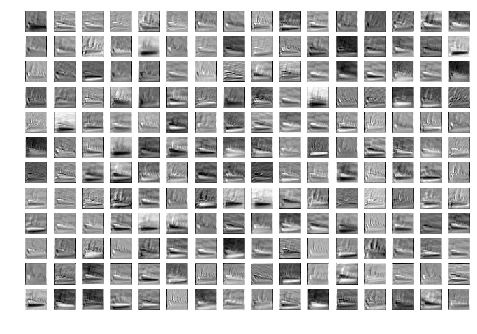

In [0]:
for _ in range(192):
    show_img = intermediate_output[:,:,:, _]
    show_img.shape = [32, 32]
    plt.subplot(12, 16, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

# NIN: mlp(10 class) output

In [0]:
a = np.array([np.where(y_test[i,]==1)[0][0] for i in range(len(y_test))]) #label of each train data
index = [np.where(a==i)[0][1] for i in range(10)] #get a index for each category

In [0]:
y_test[index]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [0]:
layer_name = 'relu9'
intermediate_layer_model = Model(inputs=model.input,                 
                                 outputs=model.get_layer(layer_name).output)#你创建新的模型
#这个新的模型截取了原始模型中从输入到某个层（你想要得到结果的那一层）的一部分，
intermediate_output = intermediate_layer_model.predict(test_x[index])#这个数据就是原始模型的输入数据，

In [0]:
intermediate_output.shape

(10, 8, 8, 10)

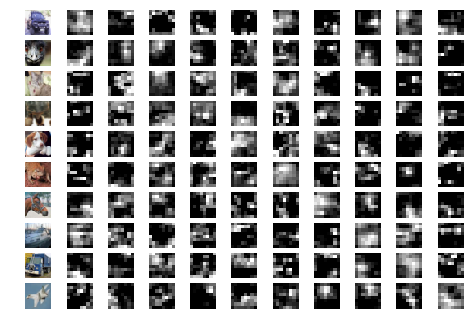

In [0]:
for i in range(10):
    plt.subplot(10,11,i*11+1)
    plt.imshow(x_test[index[i]])
    plt.axis('off')
    for j in range(10):
        show_img = intermediate_output[i,:,:, j]
        show_img.shape = [8, 8]
        plt.subplot(10, 11, i*10+_+i+2)
        plt.imshow(show_img, cmap='gray')
        plt.axis('off')
plt.show()

In [0]:
model.predict_classes(x_test[index])

array([0, 8, 2, 3, 4, 5, 6, 7, 8, 9])

**data augmentation visualization**

In [0]:
data_aug_x = np.zeros((9,32,32,3))
data_aug_y = np.zeros((9,10))
for i in range(9):
    data_aug_x[i] = x_train[0]
    data_aug_y[i] = y_train[0]

In [0]:
datagen.fit(data_aug_x)

In [0]:
for x_batch, y_batch in datagen.flow(data_aug_x, data_aug_x, batch_size=9):
    plt.subplot(4,3,1)
    plt.imshow(data_aug_x[0], cmap='gray')
    plt.axis('off')
    for i in range(9):
        plt.subplot(4,3,i+4)
        plt.imshow(x_batch[i], cmap='gray')
        plt.axis('off')
    plt.show()
    break